# **PART 1** - Collecting Data


We worked on the enviorment in the labs, so we put the installs that we nedded.

In [228]:
!pip install tweepy
!pip install plotly
import nltk
#nltk.download()
#we used the stopword corpus so please download it :)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [229]:
%matplotlib inline

In [230]:
import tweepy
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import nltk
import tweepy
from tweepy import OAuthHandler
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
#import enchant
import csv

twitter authntication and getting all our sample tweets.
we choose to keep the tweets without removing anything- since twitter only allowed 140 characters until recently and the fact we choose twiiter accoutns run by adutls, limiting the use of slang exspressions and emoji uses.
in addition, to make sure all read tweets are indeed by said gender, we didn't keep Re-Tweets.

If you like to collect new tweets from twitter run the cell below, if not you can skip this part because we saved the tweets after all the text cleaning.

In [231]:
%run twitterkeys.ipynb

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

men=["BarackObama", "realDonaldTrump", "Bud_Smith", "steveroggenbuck","AdamLevine", "ActuallyNPH", "GRRMspeaking"]
women=["MichelleObama", "Oprah", "KimKardashian", "EmmaWatson", "HillaryClinton", "IMKristenBell", "HilaryDuff"]

alltweets={}; mentweets={}; womentweets={}
ht_men=[] ; ht_women=[]
tag_men=[] ; tag_women=[]
htmen=0 ; htwomen=0
tmen=0; twomen=0
hashtag=re.compile(r"#(\w+)")
at=re.compile(r"@(\w+)")
for m in men:
    new_tweets = api.user_timeline(screen_name = m,count=200, tweet_mode="extended")
    for tweet in new_tweets:
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            if(not tweet.full_text in alltweets):
                mentweets[tweet.full_text]=0
                htmen+=len(hashtag.findall(tweet.full_text))
                tmen+=len(at.findall(tweet.full_text))
                alltweets[tweet.full_text]=0

for w in women:
    new_tweets = api.user_timeline(screen_name=w, count=200, tweet_mode="extended")
    for tweet in new_tweets:
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            if(not tweet.full_text in alltweets):
                womentweets[tweet.full_text] = 1
                htwomen+=len(hashtag.findall(tweet.full_text))
                twomen+=len(at.findall(tweet.full_text))
                alltweets[tweet.full_text]=1

In [277]:
mentocsv={}; womentocsv={}
for x in alltweets:
    if alltweets[x]==0:
        mentocsv[x]=0
    else:
        womentocsv[x]=1
(pd.DataFrame.from_dict(data=mentocsv, orient='index').to_csv('mentweets.csv', header=False))
(pd.DataFrame.from_dict(data=womentocsv, orient='index').to_csv('womentweets.csv', header=False))

Load tweets to dictionaries:

In [ ]:
mentweets=pd.read_csv('mentweets.csv', encoding='unicode_escape', header=None, index_col=0, squeeze=True).to_dict()
womentweets=pd.read_csv('womentweets.csv', encoding='unicode_escape', header=None, index_col=0, squeeze=True).to_dict()
alltweets={}
ht_men=[] ; ht_women=[]
tag_men=[] ; tag_women=[]
htmen=0 ; htwomen=0
tmen=0; twomen=0
hashtag=re.compile(r"#(\w+)")
at=re.compile(r"@(\w+)")
for tweet in mentweets:
    htmen+=len(hashtag.findall(tweet))
    tmen+=len(at.findall(tweet))
    alltweets[tweet]=0

for tweet in womentweets:
    htwomen+=len(hashtag.findall(tweet))
    twomen+=len(at.findall(tweet))
    alltweets[tweet]=1

## **basic data information**  
we choose to display how many tweets by each gander included hashtags and how many included tags.  
we did not show avg. length of tweet or number of words in tweets since the difrrence is insignificant.

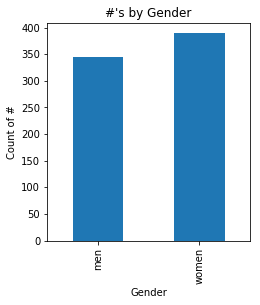

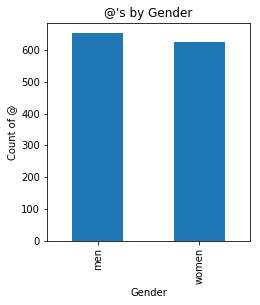

In [232]:
temp1 = pd.Series(data=[htmen,htwomen], index=['men', 'women'])
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count of #')
ax1.set_title("#'s by Gender")
temp1.plot(kind='bar')

temp2 = pd.Series(data=[tmen, twomen], index=['men', 'women'])
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count of @')
ax1.set_title("@'s by Gender")
temp2.plot(kind='bar')


# PART 2 - building a classifiar

we read that there are certain words men use more frequalty then women and vice versa,
so we calculated the number of appearnces of each stop word in each gender tweets. if the ratio of appearences is larger then 2, we won't treat the stop word as a stop word, but as a regauler word. 

In [233]:
stops = set(stopwords.words("english"))
stop_word_in_men={}
stop_word_in_women={}
for s in stops:
    stop_word_in_men[s]=0
    stop_word_in_women[s]=0
    for mt in mentweets:
        if s in mt.lower().split():
            stop_word_in_men[s]+=1
    for mt in womentweets:
        if s in mt.lower().split():
            stop_word_in_women[s]+=1
d={'1stop_word':list(stops), 'men':list(stop_word_in_men.values()), 'women':list(stop_word_in_women.values())}
df=pd.DataFrame(data=d)

#creates new list of stop words
new_stop=[]
for index, row in df.iterrows():
    if row['men']==0 or row['women']==0:
        if(abs(row['men']-row['women'])<5):
            new_stop.append(row['1stop_word'])
    elif row['men']/row['women']<2.0 and row['women']/row['men']<2.0:
        new_stop.append(row['1stop_word'])

## building the classifier

In [234]:
ht_men.extend(ht_women)
tag_men.extend(tag_women)

In [235]:
#combine tweets to single dataframe
bloop={'tweet':list(alltweets.keys()), 'gender':list(alltweets.values())}
bb=pd.DataFrame(data=bloop)
   
#clean stop words
def tweet_to_words(raw_tweet):
    words = raw_tweet.lower().split()
    meaningful_words = [w for w in words if not w in new_stop]
    return( " ".join( meaningful_words ))

clean_train_reviews = []

for i in alltweets:
    clean_train_reviews.append(tweet_to_words(i))
def bow(clean_train_reviews):
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features=1000)
    train_data_features = vectorizer.fit_transform(clean_train_reviews)
    return train_data_features.toarray()

train_data_features=bow(clean_train_reviews)
#split to train & test
msk = np.random.rand(len(bb)) < 0.8
train_x = train_data_features[msk]
test_x = train_data_features[~msk]
train_y = bb.loc[msk,"gender"]
test_y = bb.loc[~msk,"gender"]

### Random Forest Classifier: 
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

In [236]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(train_x, train_y)
f=forest.score(test_x,test_y)

### Gradient Boosting Classifier:
GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

In [237]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(n_estimators=10, max_depth=3, min_samples_split=15)
gbc.fit(train_x,train_y)
g=gbc.score(test_x,test_y)

### Linear Discriminant Analysis:
Linear Discriminant Analysis a classifier with a linear decision surface. This classifier is attractive because it have closed-form solutions that can be easily computed, are inherently multiclass, have proven to work well in practice and have no hyperparameters to tune. We choose the shrinkage='auto' and the solver='lsqr' because they maximized our accuracy.

In [238]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
lda.fit(train_x,train_y)
l=lda.score(test_x,test_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



### Passive Aggressive Classifier:
The passive-aggressive algorithms are a family of algorithms for large-scale learning. They are similar to the Perceptron in that they do not require a learning rate. 

In [239]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac =PassiveAggressiveClassifier(random_state=0)
pac.fit(train_x,train_y)
p=pac.score(test_x,test_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



### K Neighbors Classifier:
Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

In [240]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_x,train_y)
k=kn.score(test_x,test_y)

### Ada Boost Classifier:
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [241]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
bdt.fit(train_x,train_y)
b=bdt.score(test_x,test_y)

### Voting Classifier: we're using the top 3 classifiers
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In [242]:
from sklearn.ensemble import VotingClassifier
vote = VotingClassifier(estimators=[('pac', pac), ('lda', lda), ('forest', forest)], voting='hard')
vote.fit(train_x,train_y)
v=vote.score(test_x,test_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



### all results:

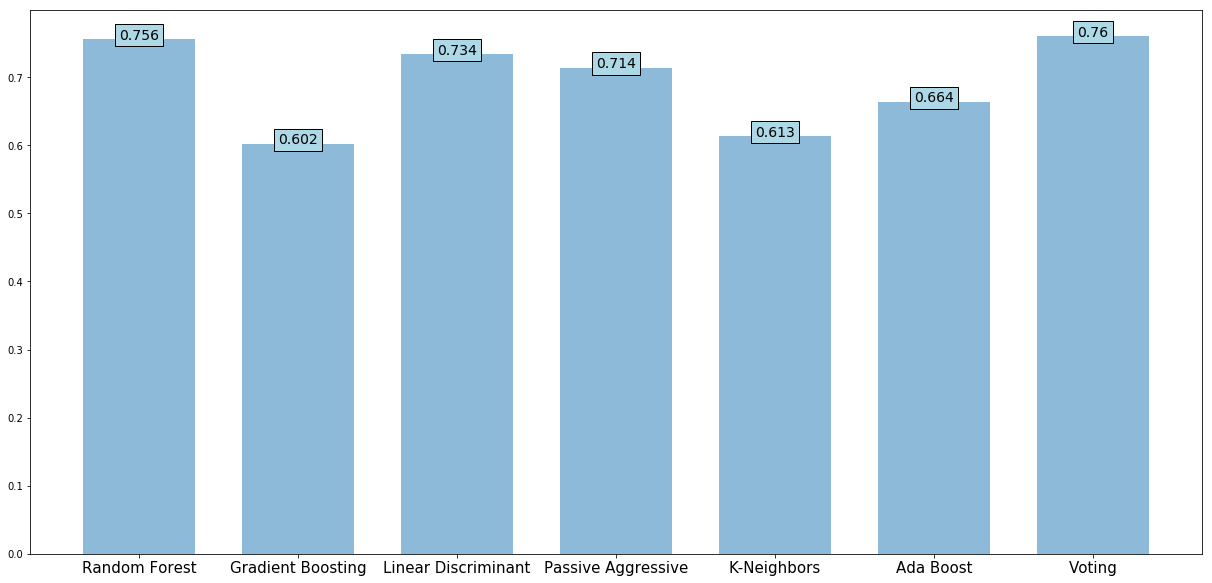

In [243]:
import plotly.plotly as py
import matplotlib.pyplot as plt
dictionary = plt.figure(figsize=(21,10))
x = {u'Random Forest':f, u'Gradient Boosting': g, u'Linear Discriminant':l , u'Passive Aggressive':p, u'K-Neighbors':k, u'Ada Boost':b, u'Voting':v}
y = [f, g, l, p, k, b, v]
z=range(7)
plt.bar(range(len(x)), x.values(), align='center', alpha=0.5, width=0.7)
plt.xticks(range(len(x)), x.keys(),size=15)
for a,b in zip(z,y):
    plt.text(a,b,str(round(b,3)), horizontalalignment='center', fontsize=14, bbox=dict(facecolor='lightblue'))
plt.show()

# Part 3 - creating our own male and female tweets

In [244]:
!pip install theano
#please change "backend" to theano in keras.json
import numpy as np
import pandas as pd
import theano
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras import backend as K

extract tweets and create a model for each gender:

In [245]:
def create_model(text):
    vocabulary_size = 600
    text2 = text_to_word_sequence(text, filters='!"$%&()*+,-./:;<=>?[\\]^_`{|}~\t\n',lower=True, split=" ")
    token = Tokenizer(nb_words=600, char_level=False)
    token.fit_on_texts(text2)
    text_mtx = token.texts_to_matrix(text2, mode='binary')
    vocab = pd.DataFrame({'word': text2, 'code': np.argmax(text_mtx, axis=1)})
    vocab = vocab.drop_duplicates().sort_values('code')
    input_ = text_mtx[:-1]
    output_ = text_mtx[1:]

    model = Sequential()
    model.add(Embedding(input_dim=input_.shape[1], output_dim=42, input_length=input_.shape[1]))
    model.add(Flatten())
    model.add(Dense(output_.shape[1], activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])
    model.fit(input_, y=output_, batch_size=200, nb_epoch=20, verbose=1, validation_split=0.2)
    score = model.evaluate(input_,output_, verbose=0)
    print(score)

    model.save_weights('weights_1')
    model.load_weights('weights_1')
    score = model.evaluate(input_,output_, verbose=0)
    y_test_pred = model.predict_classes(input_, verbose=0)
    y_test_pred.shape
    np.argmax(output_[:150:10],axis=1)
    y_test_pred[:150:10]
    probs = model.predict_proba(input_, verbose=0)
    probs[1]
    return token,model,vocab

#seperating each tweet by "NEWTWEET"
string_of_male_tweets=' NEWTWEET '
for t in mentweets:
    string_of_male_tweets+= t
    string_of_male_tweets+=' NEWTWEET '
    
mtokem, mmodel, mvocab=create_model(string_of_male_tweets)

string_of_female_tweets=' NEWTWEET '
for t in womentweets:
    string_of_female_tweets+= t
    string_of_female_tweets+=' NEWTWEET '
    
ftokem, fmodel, fvocab=create_model(string_of_female_tweets)

C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\text.py:145: UserWarning:

The `nb_words` argument in `Tokenizer` has been renamed `num_words`.

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 22184 samples, validate on 5546 samples
Epoch 1/20
22184/22184 [==============================] - 48s - loss: 3.8471 - acc: 0.0392 - val_loss: 3.4691 - val_acc: 0.0453
Epoch 2/20
22184/22184 [==============================] - 40s - loss: 3.6764 - acc: 0.0543 - val_loss: 3.2740 - val_acc: 0.1612
Epoch 3/20
22184/22184 [==============================] - 40s - loss: 3.4176 - acc: 0.1179 - val_loss: 2.9876 - val_acc: 0.1756
Epoch 4/20
22184/22184 [==============================] - 40s - loss: 3.1932 - acc: 0.1345 - val_loss: 2.9044 - val_acc: 0.1830
Epoch 5/20
22184/22184 [==============================] - 40s - loss: 3.0297 - acc: 0.1445 - val_loss: 2.8808 - val_acc: 0.1854
Epoch 6/20
22184/22184 [==============================] - 40s - loss: 2.8977 - acc: 0.1552 - val_loss: 2.8929 - val_acc: 0.1882
Epoch 7/20
22184/22184 [==============================] - 40s - loss: 2.7998 - acc: 0.1622 - val_loss: 2.9126 - val_acc: 0.1891
Epoch 8/20
22184/22184 [==============================]

Functions we will use to create a tweet

In [246]:
import random

def get_next(text,token,model,vocabulary):
    #Predicts the following word, given a text word, a tokenizer to convert it to 1-hot vector, a trained model and a vocabulary
    #with word and index representations
    #converting the word to 1-hot matrix represenation
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    #predicting next word
    p = model.predict(tmp)[0]
    match = find_random_word_index(p)
    return vocabulary[vocabulary['code']==match]['word'].values[0]

def find_random_word_index(v):
    found = False
    while found == False:
        index_rand_choice = random.randint(0, len(v) - 1)
        if v[index_rand_choice] != 0:
            return index_rand_choice
    return None


def create_tweet(token, model, vocab):
    prev_word = 'NEWTWEET'
    next_word = ''
    tweet = '';
    chars = 0
    while (chars<140 and next_word.strip() != 'NEWTWEET'):
        next_word = get_next(prev_word, token, model, vocab)
        tweet = tweet + " " + next_word
        prev_word = next_word
        chars+=len(next_word)
        if not (chars<140 and next_word.strip() != 'NEWTWEET'):
            break
    return tweet

create a set of tweets for each gender (dont run this if you don't want to generate new tweets):

In [247]:
allmen=[]
allwomen=[]
for i in range(0, 400):
    men = create_tweet(mtokem, mmodel, mvocab)
    allmen.append(men)

for i in range(0, 400):
    female = create_tweet(ftokem, fmodel, fvocab)
    allwomen.append(female)

Writing to csv:

In [306]:
df1 = pd.DataFrame(data=allmen)
df1.to_csv("allmen.csv", sep=',',index=False, header=False)
df2 = pd.DataFrame(data=allwomen)
df2.to_csv("allwomen.csv", sep=',',index=False, header=False)

In [ ]:
allmen=[]
with open('allmen.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        allmen.append(row[0])
allwomen=[]
with open('allwomen.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        allwomen.append(row[0])

# Part 4 - Checking our classifier on our new tweets
we will check our tweets using the top 3 classifiers as seen in model fitting (with different tweets we recieve different scores).

In [248]:
mentweets=[]; womentweets=[]
for tweet in allmen:
    if(not tweet in mentweets):
        mentweets.append(tweet)
        
for tweet in allwomen:
    if(not tweet in womentweets):
        womentweets.append(tweet)
mentweets.extend(alltweets.keys())
womentweets.extend(alltweets.keys())

as before, we will check the ratio of each stopword between men and women and create a new stop word list.

In [249]:
stop_word_in_men={}
stop_word_in_women={}
for s in stops:
    stop_word_in_men[s]=0
    stop_word_in_women[s]=0
    for mt in mentweets:
        if s in mt.lower().split():
            stop_word_in_men[s]+=1
    for mt in womentweets:
        if s in mt.lower().split():
            stop_word_in_women[s]+=1
d={'1stop_word':list(stops), 'men':list(stop_word_in_men.values()), 'women':list(stop_word_in_women.values())}
df=pd.DataFrame(data=d)

#creates new list of stop words
for index, row in df.iterrows():
    if row['men']==0 or row['women']==0:
        if(abs(row['men']-row['women'])<5):
            new_stop.append(row['1stop_word'])
    elif row['men']/row['women']<2.0 and row['women']/row['men']<2.0:
        new_stop.append(row['1stop_word'])


check the classification prediction for each feamle tweet for the top three classifiers.

In [257]:
clean_train_reviews=[]
for i in mentweets:
    clean_train_reviews.append(tweet_to_words(i))
# The vocabulary after the Bag of Words model is trained:
train_data_features = bow(clean_train_reviews)
forest_true = 0
pac_true = 0
vote_true = 0
forest_predicted_tweets=[]
real_tweets=[]
pac_predicted_tweets=[]
vote_predicted_tweets=[]
for i in range(0, 400):
    real_tweets.append('men')
    if forest.predict([train_data_features[i]]) == 0 :
        forest_true = forest_true + 1
        forest_predicted_tweets.append('men')
    else:
        forest_predicted_tweets.append('women')
    if pac.predict([train_data_features[i]]) == 0 :
        pac_true = pac_true + 1
        pac_predicted_tweets.append('men')
    else:
        pac_predicted_tweets.append('women')
    if vote.predict([train_data_features[i]]) == 0 :
        vote_true = vote_true + 1
        vote_predicted_tweets.append('men')
    else:
        vote_predicted_tweets.append('women')
print("forest score: "+str(forest_true/400))
print("passive-aggressive score: "+str(pac_true/400))
print("voting score: "+str(vote_true/400))

forest score: 0.445
passive-aggressive score: 0.8
voting score: 0.69


check the classification prediction for each feamle tweet for the top three classifiers.

In [258]:
clean_train_reviews=[]
for i in womentweets:
    clean_train_reviews.append(tweet_to_words(i))
train_data_features = bow(clean_train_reviews)
forest_true = 0
pac_true = 0
vote_true = 0

for i in range(0, 400):
    real_tweets.append('women')
    if forest.predict([train_data_features[i]]) == 1 :
        forest_true = forest_true + 1
        forest_predicted_tweets.append('women')
    else:
        forest_predicted_tweets.append('men')
    if pac.predict([train_data_features[i]]) == 1 :
        pac_true = pac_true + 1
        pac_predicted_tweets.append('women')
    else:
        pac_predicted_tweets.append('men')
    if vote.predict([train_data_features[i]]) == 1 :
        vote_true = vote_true + 1
        vote_predicted_tweets.append('women')
    else:
        vote_predicted_tweets.append('men')
print("forest score: "+str(forest_true/400))
print("passive-aggressive score: "+str(pac_true/400))
print("voting score: "+str(vote_true/400))

forest score: 0.8575
passive-aggressive score: 0.4725
voting score: 0.6725


### Confusion matrix random forest:

Confusion matrix, without normalization
[[178 222]
 [ 57 343]]


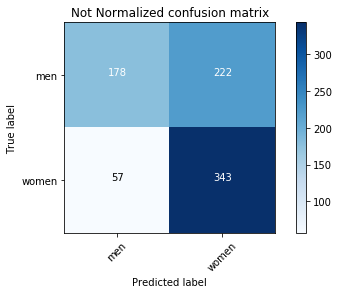

In [259]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=['men', 'women']
mat_forest = confusion_matrix(real_tweets,forest_predicted_tweets)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(mat_forest, classes=class_names, normalize=False,
                      title='Not Normalized confusion matrix')

### Confusion matrix passive-aggressive:

Confusion matrix, without normalization
[[320  80]
 [211 189]]


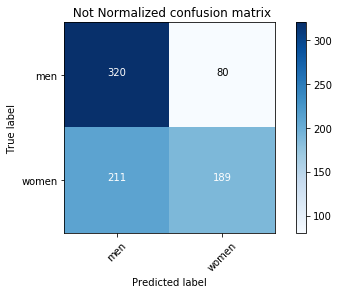

In [260]:
mat_pac = confusion_matrix(real_tweets,pac_predicted_tweets)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(mat_pac, classes=class_names, normalize=False,
                      title=' Not Normalized confusion matrix')

### Confusion matrix voting:

Confusion matrix, without normalization
[[276 124]
 [131 269]]


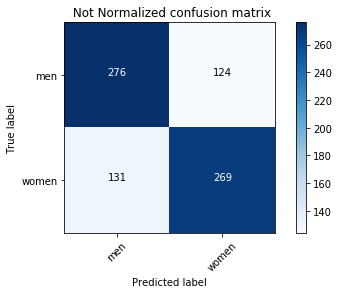

In [261]:
mat_vote = confusion_matrix(real_tweets,vote_predicted_tweets)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(mat_vote, classes=class_names, normalize=False,
                      title=' Not Normalized confusion matrix')

## Conclusions

different classifications work best for the different genders. We would like to check the influence of emoji, hastags, retweets, picture posting (link to instagram etc.) as features in addition to the text classifier.